<a href="https://colab.research.google.com/github/DiegoLeon96/Neural-Speech-Dereverberation/blob/main/WPE_dereverberation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display as display
import librosa.feature
import soundfile as sf
import os
import sys
import torch
import cv2
import random
import math

# Utils

In [ ]:
def extract_audio(filename):
    """
    Generate waveform given filename (.wav, .flac, etc)
    """
    audio, rate = sf.read(filename, always_2d=True)
    audio = np.reshape(audio, (1,-1))
    audio = audio[0]
    
    time = []
    t=0
    for i in range(len(audio)):
        time.append(t)
        t+=1/rate
    return audio, time, rate

def generate_spec(audio_sequence, rate, n_fft=2048, hop_length=512):
  """
  generate spectrogram using Librosa

  audio_sequence: list containing waveform
  rate: sampling rate
  n_fft, hop_length: stft parameters

  return log power spectra
  """
  S = librosa.feature.melspectrogram(audio_sequence, sr=rate, n_fft=n_fft, hop_length=hop_length, n_mels=128, fmin=20, fmax=8300)
  log_spectra = librosa.power_to_db(S, ref=np.mean, top_db=80)
  return log_spectra

def graph_spec(spec, rate = 16000, title = False):
  """
  plot spectrogram 
  spec: spectrogram generated using Librosa
  rate: sampling rate
  """
  plt.figure()
  display.specshow(spec, sr=rate, y_axis='mel', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  if (title):
    plt.title('Log-Power spectrogram')
  plt.tight_layout()

def reconstruct_wave(spec, rate = 16000, normalize_data = False):
  """
  Reconstruct waveform
  spec: spectrogram generated using Librosa
  rate: sampling rate
  """
  power = librosa.db_to_power(spec, ref = 5.0)
  audio = librosa.feature.inverse.mel_to_audio(power, sr = rate, n_fft = 2048, hop_length = 512)
  out_audio = audio/np.max(audio) if normalize_data else audio 
  return out_audio

def plot_time_wave(audio, rate = 16000):
  """
  plot waveform given speech audio
  audio: array containing waveform
  rate: sampling rate
  
  """
  time = [0]
  for i in range(1, len(audio)):
    time.append(time[i-1] + 1/rate)

  plt.figure()
  plt.plot(time, audio)
  plt.xlabel("Time (secs)")
  plt.ylabel("Power")


def normalize(spec, eps=1e-6):
  """
  Normalize spectrogram with zero mean and unitary variance
  spec: spectrogram generated using Librosa
  """
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  return spec_norm, (mean, std)

# fdndlp implementation

Implementation https://github.com/helianvine/fdndlp

In [ ]:
# Created by Teng Xiang at 2018-08-10
# Current version: 2018-08-10 
# https://github.com/helianvine/fdndlp
# =============================================================================

import numpy as np
from numpy.lib import stride_tricks

def stft(data, frame_size=512, overlap=0.75, window=None):
    """ Multi-channel short time fourier transform 
    Args:
        data: A 2-dimension numpy array with shape=(channels, samples)
        frame_size: An integer number of the length of the frame
        overlap: A float nonnegative number less than 1 indicating the overlap
                 factor between adjacent frames
    Return:
        A 3-dimension numpy array with shape=(channels, frames, frequency_bins) 
    """
    assert(data.ndim == 2)
    if window == None:
        window = np.hanning(frame_size) 
    frame_shift = int(frame_size - np.floor(overlap * frame_size))
    cols = int(np.ceil((data.shape[1] - frame_size) / frame_shift)) + 1
    data = np.concatenate(
        (data, np.zeros((data.shape[0], frame_shift), dtype = np.float32)),
        axis = 1)
    samples = data.copy()
    frames = stride_tricks.as_strided(
        samples,
        shape=(samples.shape[0], cols, frame_size),
        strides=(
            samples.strides[-2], 
            samples.strides[-1] * frame_shift, 
            samples.strides[-1])).copy()
    frames *= window
    return np.fft.rfft(frames)

def istft(data, frame_size=None, overlap=0.75, window=None):
    """ Multi-channel inverse short time fourier transform
    Args:
        data: A 3-dimension numpy array with shape=(channels, frames, frequency_bins) 
        frame_size: An integer number of the length of the frame
        overlap: A float nonnegative number less than 1 indicating the overlap
                 factor between adjacent frames
    Return:
        A 2-dimension numpy array with shape=(channels, samples)
    """
    assert(data.ndim == 3)
    real_data = np.fft.irfft(data)
    if frame_size == None:
        frame_size = real_data.shape[-1]
    frame_num = data.shape[-2]
    frame_shift = int(frame_size - np.floor(frame_size * overlap))
    length = (frame_num - 1) * frame_shift + frame_size
    output = np.zeros((data.shape[0], length))
    for i in range(frame_num):
        index = i*frame_shift
        output[:, index : index + frame_size] += real_data[:,i]
    return output
    
def log_spectrum(raw_data, frame_length=512):
    """Log magnitude spectrogram"""
    if raw_data.ndim == 1:
        raw_data = np.reshape(raw_data, (1, -1))
    freq_data = stft(raw_data)
    phase = np.angle(freq_data)
    freq_data = np.abs(freq_data)
    freq_data = np.maximum(freq_data, 1e-8)
    log_data = np.log10(freq_data / freq_data.min())
    return log_data, phase

In [ ]:
# Created by Teng Xiang at 2018-08-10
# Current version: 2018-08-10 
# https://github.com/helianvine/fdndlp
# =============================================================================

""" Weighted prediction error(WPE) method for speech dereverberation."""
import argparse
import time
import os
import numpy as np
import soundfile as sf
from numpy.lib import stride_tricks
# import matplotlib.pyplot as plt

class Configrations():
    """Argument parser for WPE method configurations."""
    def __init__(self):
        self.parser = argparse.ArgumentParser()

    def parse(self):
        self.parser.add_argument('filename')
        self.parser.add_argument(
            '-o', '--output', default='drv.wav',
            help='output filename')
        self.parser.add_argument(
            '-m', '--mic_num', type=int, default=3,
            help='number of input channels')
        self.parser.add_argument(
            '-n','--out_num', type=int, default=2,
            help='number of output channels')
        self.parser.add_argument(
            '-p', '--order', type=int, default=30,
            help='predition order')
        self.cfgs = self.parser.parse_args()
        return self.cfgs


class WpeMethod(object):
    """WPE metheod for speech dereverberaiton 
    Weighted prediction errors (WPE) method is an outstanding speech 
    derverberation algorithm, which is based on the multi-channel linear
    prediction algorithm and produces multi-channel output.
    Attributes:
        channels: Number of input channels.
        out_num: Number of output channels.
        p: An integer number of the prediction order.
        d: An integer number of the prediction delay.
        frame_size: An integer number of the length of the frame
        overlap: A float nonnegative number less than 1 indicating the overlap
                 factor between adjacent frames
    """
    def __init__(self, mic_num, out_num, order=30):
        self.channels = mic_num
        self.out_num = out_num
        self.p = order
        self.d = 2
        self.frame_size = 512
        self.overlap = 0.5
        self._iterations = 2
    
    @property
    def iterations(self):
        return self._iterations

    @iterations.setter
    def iterations(self, value):
        assert(int(value) > 0)
        self._iterations = int(value)

    def _display_cfgs(self):
        print('\nSettings:')
        print("Input channel: %d" % self.channels)
        print("Output channel: %d" % self.out_num)
        print("Prediction order: %d\n" % self.p)


    def run_offline(self, data):
        time_start = time.time()
        drv_data = self.__fdndlp(data)
        return drv_data

    def __fdndlp(self, data):
        """Frequency-domain variance-normalized delayed liner prediction 
        This is the core part of the WPE method. The variance-normalized 
        linear prediciton algorithm is implemented in each frequency bin 
        separately. Both the input and output signals are in time-domain.  
        Args:
            data: A 2-dimension numpy array with shape=(chanels, samples)
        Returns:
            A 2-dimension numpy array with shape=(output_channels, samples)
        """

        freq_data = stft(
            data / np.abs(data).max(), 
            frame_size=self.frame_size, overlap=self.overlap)
        self.freq_num = freq_data.shape[-1]
        drv_freq_data = freq_data[0:self.out_num].copy()
        for i in range(self.freq_num):
            xk = freq_data[:,:,i].T
            dk = self.__ndlp(xk)
            drv_freq_data[:,:,i] = dk.T
        drv_data = istft(
            drv_freq_data, 
            frame_size=self.frame_size, overlap=self.overlap)
        return drv_data / np.abs(drv_data).max()


    def __ndlp(self, xk):
        """Variance-normalized delayed liner prediction 
        Here is the specific WPE algorithm implementation. The input should be
        the reverberant time-frequency signal in a single frequency bin and 
        the output will be the dereverberated signal in the corresponding 
        frequency bin.
        Args:
            xk: A 2-dimension numpy array with shape=(frames, input_chanels)
        Returns:
            A 2-dimension numpy array with shape=(frames, output_channels)
        """
        cols = xk.shape[0] - self.d
        xk_buf = xk[:,0:self.out_num]
        xk = np.concatenate(
            (np.zeros((self.p - 1, self.channels)), xk),
            axis=0)
        xk_tmp = xk[:,::-1].copy()
        frames = stride_tricks.as_strided(
            xk_tmp,
            shape=(self.channels * self.p, cols),
            strides=(xk_tmp.strides[-1], xk_tmp.strides[-1]*self.channels))
        frames = frames[::-1]
        sigma2 = np.mean(1 / (np.abs(xk_buf[self.d:]) ** 2), axis=1)
        for _ in range(self.iterations):
            x_cor_m = np.dot(
                    np.dot(frames, np.diag(sigma2)),
                    np.conj(frames.T))
            x_cor_v = np.dot(
                frames, 
                np.conj(xk_buf[self.d:] * sigma2.reshape(-1, 1)))
            coeffs = np.dot(np.linalg.inv(x_cor_m + 1e-6*np.identity(x_cor_m.shape[0])), x_cor_v)
            #coeffs = np.dot(np.linalg.inv(x_cor_m), x_cor_v)
            dk = xk_buf[self.d:] - np.dot(frames.T, np.conj(coeffs))
            sigma2 = np.mean(1 / (np.abs(dk) ** 2), axis=1)
        return np.concatenate((xk_buf[0:self.d], dk))

    def load_audio(self, filename):
        data, fs = sf.read(filename, always_2d=True)
        data = data.T
        assert(data.shape[0] >= self.channels)
        if data.shape[0] > self.channels:
            print(
                "The number of the input channels is %d," % data.shape[0],
                "and only the first %d channels are loaded." % self.channels)
            data = data[0: self.channels]
        return data.copy(), fs

    def write_wav(self, data, fs, filename, path='wav_out'):
        if not os.path.exists(path):
            os.makedirs(path)
        filepath = os.path.join(path, filename)
        print('Write to file: %s.' % filepath)
        sf.write(filepath, data.T, fs, subtype='PCM_16')


## Qualitative Evaluation

In [ ]:
def evaluate_qualitative(audio_dirs, num_example, speech_rate=16000):
  """
  audio_dirs: list of directories containing reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  waves_target = torch.load(audio_dirs[0])
  waves_rev = torch.load(audio_dirs[1])

  wpe = WpeMethod(1, 1, 90)

  rev_spec = generate_spec(waves_rev[num_example], speech_rate)
  orig_spec = generate_spec(waves_target[num_example], speech_rate)
  graph_spec(orig_spec)
  graph_spec(rev_spec)

  raw_drv_data = wpe.run_offline(np.reshape(np.array(waves_rev[num_example]), (1, -1)))
  raw_drv_data = np.reshape(raw_drv_data, (raw_drv_data.shape[1],))
  drv_data = raw_drv_data[0:len(waves_target[num_example])]

  drv_spec = generate_spec(drv_data, speech_rate)
  graph_spec(drv_spec)

In [ ]:
dir_list = ['/content/drive/My Drive/data_audio/wavetarget', '/content/drive/My Drive/data_audio/waverev']

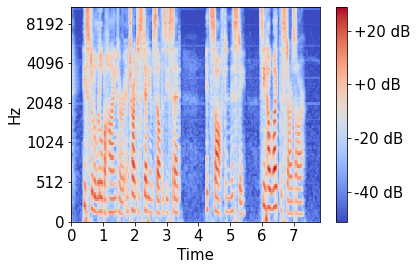

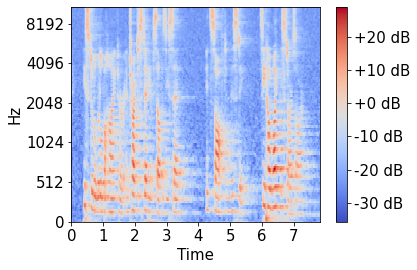

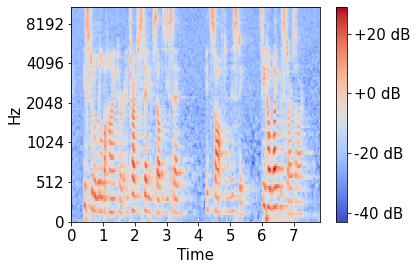

In [ ]:
evaluate_qualitative(dir_list, 100)

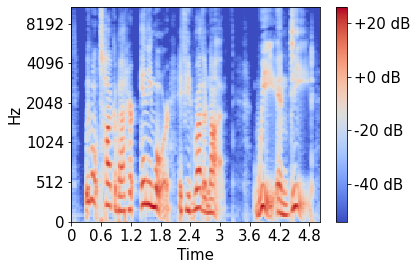

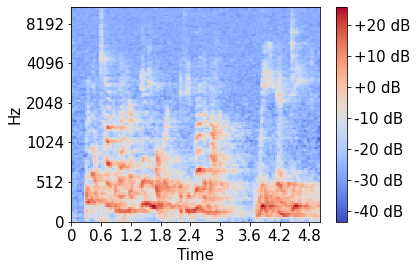

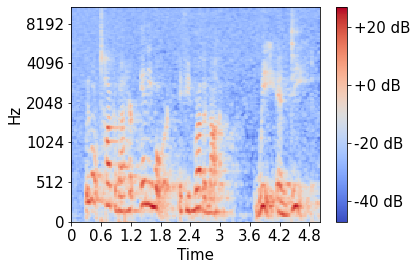

In [ ]:
evaluate_qualitative(dir_list, 300)

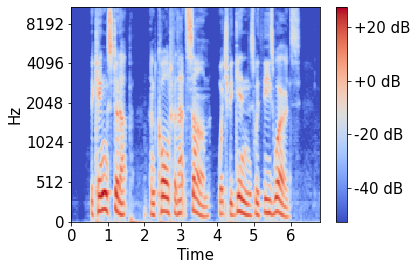

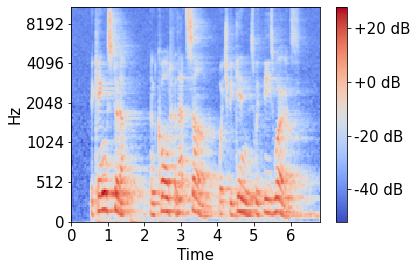

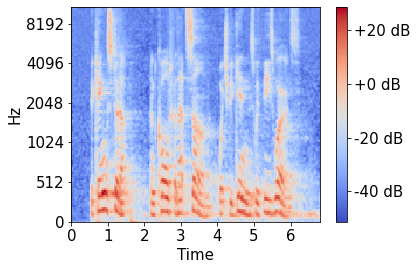

In [ ]:
evaluate_qualitative(dir_list, 400)

# Quantitative Evaluation

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     \ 2.0MB 2.3MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     | 276kB 33.9MB/s
     | 71kB 45.5MB/s
     \ 65.2MB 47kB/s
     |████████████████████████████████| 163kB 5.3MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp36-none-any.whl size=24291 sha256=56ba1e967198c8738d556f8022f395344d3ec18e59cae1514749046748c52269
  Stored in directory: /tmp/pip-ephem-wheel-cache-n0ym2k0v/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pesq: filename=pesq-0.0.2-cp36-cp36m-linux_x86_64.whl size=161306 sha256=6e78174892957e139db5edc18d3691e457df14aa8c9231db0649037f8bc3ad32
  Stored in directory: /tmp/pip-ephem-wheel-cache-n0ym2k0v/wheels/85/91/09/5ae7677a054a05d49111dc8f3b282e886b3852348384893a32
  Created wheel for SRMRpy: filename=SRMRpy-1.0-cp36-none-any.whl size=9397 sha256=2b60ac4a456882f2b32104fa68401fd9b0c1d16333a74ee2980b8338fa981313
 

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import *
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp36-cp36m-linux_x86_64.whl size=82990 sha256=f27a81d783287c0ba41b9ea514c2f23f8842e63d1b711bbff30a8d1f518029e9
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate_wpe(lower_bound, upper_bound, path_vector, initial = True):
  """
  lower_bound: first example to be considered
  upper_bound: last example to be considered
  path_vector: list of directories -> dir to save results, dir where reverberant waveforms are
                                     dir where clean waveforms are
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  """

  path = path_vector[0]
  path_rev = path_vector[1]
  path_targets = path_vector[2]
  
  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe')
    reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe')
    reverb_llr_list = torch.load(path + 'reverb_llr_wpe')
    reverb_cd_list = torch.load(path + 'reverb_cd_wpe')
    reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe')
    reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')

    dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe')
    dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe')
    dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe')
    dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe')
    dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')

  
  wave_rev = torch.load(path_rev)
  wave_targets = torch.load(path_targets)

  speech_rate = 16000

  for i in range(lower_bound, upper_bound):
    print("Processing audio file n°" + str(i+1))
    
    try:
    
      wpe = WpeMethod(1, 1, 90)

      raw_drv_data = wpe.run_offline(np.reshape(np.array(wave_rev[i]), (1, -1)))
      
      raw_drv_data = np.reshape(raw_drv_data, (raw_drv_data.shape[1],))
      drv_data = raw_drv_data[0:len(wave_targets[i])]

      speech_audio = wave_targets[i]
      speech_rev = wave_rev[i]

      pesq_metric_rev = pesq(speech_audio, speech_rev, fs = speech_rate)
      stoi_metric_rev = stoi(speech_audio, speech_rev, speech_rate)
      llr_metric_rev = llr(speech_audio, speech_rev, speech_rate)
      cd_metric_rev = cepstrum_distance(speech_audio, speech_rev, speech_rate)
      fwSNRseg_metric_rev = fwSNRseg(speech_audio, speech_rev, speech_rate)
      srmr_metric_rev = srmr(wave_rev[i], speech_rate)

      pesq_metric_recon = pesq(speech_audio, drv_data, fs = speech_rate)
      stoi_metric_recon = stoi(speech_audio, drv_data, speech_rate)
      llr_metric_recon = llr(speech_audio, drv_data, speech_rate)
      cd_metric_recon = cepstrum_distance(speech_audio, drv_data, speech_rate)
      fwSNRseg_metric_recon = fwSNRseg(speech_audio, drv_data, speech_rate)
      srmr_metric_recon = srmr(raw_drv_data, speech_rate)

      reverb_pesq_list.append(pesq_metric_rev)
      reverb_stoi_list.append(stoi_metric_rev)
      reverb_llr_list.append(llr_metric_rev)
      reverb_cd_list.append(cd_metric_rev)
      reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
      reverb_srmr_list.append(srmr_metric_rev)

      dereverb_pesq_list.append(pesq_metric_recon)
      dereverb_stoi_list.append(stoi_metric_recon)
      dereverb_llr_list.append(llr_metric_recon)
      dereverb_cd_list.append(cd_metric_recon)
      dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
      print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
      print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
      print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
      print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')  
      
    
    except (librosa.feature.inverse.ParameterError, np.linalg.LinAlgError):
      pass

  
    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path + 'reverb_pesq_wpe')
      torch.save(reverb_stoi_list, path + 'reverb_stoi_wpe')
      torch.save(reverb_llr_list, path + 'reverb_llr_wpe')
      torch.save(reverb_cd_list, path + 'reverb_cd_wpe')
      torch.save(reverb_fwSNRseg_list, path + 'reverb_fwSNRseg_wpe')
      torch.save(reverb_srmr_list, path + 'reverb_srmr_wpe')

      torch.save(dereverb_pesq_list, path + 'dereverb_pesq_wpe')
      torch.save(dereverb_stoi_list, path + 'dereverb_stoi_wpe')
      torch.save(dereverb_llr_list, path + 'dereverb_llr_wpe')
      torch.save(dereverb_cd_list, path + 'dereverb_cd_wpe')
      torch.save(dereverb_fwSNRseg_list, path + 'dereverb_fwSNRseg_wpe')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_wpe')
      print('Saved')


## Simulated room 1

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/', '/content/drive/My Drive/data_audio/waverev', '/content/drive/My Drive/data_audio/wavetarget']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.241 || PESQ dereverberated signal: 2.599
STOI reverberated signal: 0.840 || STOI dereverberated signal: 0.892
LLR reverberated signal: 0.341 || LLR dereverberated signal: 0.240
CD reverberated signal: 3.498 || CD dereverberated signal: 2.775
fwSNRseg reverberated signal: 9.593 || fwSNRseg dereverberated signal: 11.849
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 4.118


Processing audio file n°2
PESQ reverberated signal: 2.171 || PESQ dereverberated signal: 2.497
STOI reverberated signal: 0.808 || STOI dereverberated signal: 0.863
LLR reverberated signal: 0.377 || LLR dereverberated signal: 0.259
CD reverberated signal: 3.738 || CD dereverberated signal: 2.959
fwSNRseg reverberated signal: 8.344 || fwSNRseg dereverberated signal: 10.490
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 4.816


Processing audio file n°3
PESQ reverberated signal: 2.146 || PESQ dereverberated signal: 2.515
STOI reverberat

In [ ]:
path = '/content/drive/My Drive/metrics_audio/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.11
STOI: 0.84
LLR: 0.81
CD: 5.39
fwSNRseg: 7.69
SRMR: 3.17

Dereverberated signal:
PESQ: 2.31
STOI: 0.86
LLR: 0.82
CD: 5.26
fwSNRseg: 8.86
SRMR: 4.55


## Simulated Room 2

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/room2/', '/content/drive/My Drive/data_audio/waverev_2', '/content/drive/My Drive/data_audio/wavetarget_2']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.296 || PESQ dereverberated signal: 2.400
STOI reverberated signal: 0.614 || STOI dereverberated signal: 0.640
LLR reverberated signal: 1.095 || LLR dereverberated signal: 1.100
CD reverberated signal: 6.273 || CD dereverberated signal: 6.291
fwSNRseg reverberated signal: 7.129 || fwSNRseg dereverberated signal: 7.437
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 3.425


Processing audio file n°2
PESQ reverberated signal: 2.240 || PESQ dereverberated signal: 2.314
STOI reverberated signal: 0.670 || STOI dereverberated signal: 0.686
LLR reverberated signal: 1.256 || LLR dereverberated signal: 1.247
CD reverberated signal: 6.942 || CD dereverberated signal: 6.941
fwSNRseg reverberated signal: 6.317 || fwSNRseg dereverberated signal: 6.463
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 3.295


Processing audio file n°3
PESQ reverberated signal: 2.191 || PESQ dereverberated signal: 2.285
STOI reverberated

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.15
STOI: 0.67
LLR: 0.97
CD: 5.71
fwSNRseg: 6.58
SRMR: 4.49

Dereverberated signal:
PESQ: 2.24
STOI: 0.67
LLR: 1.00
CD: 5.83
fwSNRseg: 6.60
SRMR: 5.34


## Room Simulated 3

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/room3/', '/content/drive/My Drive/data_audio/waverev_3', '/content/drive/My Drive/data_audio/wavetarget_3']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.574 || PESQ dereverberated signal: 2.699
STOI reverberated signal: 0.762 || STOI dereverberated signal: 0.780
LLR reverberated signal: 1.021 || LLR dereverberated signal: 1.024
CD reverberated signal: 6.051 || CD dereverberated signal: 6.096
fwSNRseg reverberated signal: 9.153 || fwSNRseg dereverberated signal: 9.512
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 3.970


Processing audio file n°2
PESQ reverberated signal: 2.540 || PESQ dereverberated signal: 2.670
STOI reverberated signal: 0.799 || STOI dereverberated signal: 0.812
LLR reverberated signal: 1.174 || LLR dereverberated signal: 1.173
CD reverberated signal: 6.630 || CD dereverberated signal: 6.652
fwSNRseg reverberated signal: 7.911 || fwSNRseg dereverberated signal: 8.333
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 4.139


Processing audio file n°3
PESQ reverberated signal: 2.588 || PESQ dereverberated signal: 2.741
STOI reverberated

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.57
STOI: 0.83
LLR: 0.85
CD: 5.25
fwSNRseg: 8.68
SRMR: 5.21

Dereverberated signal:
PESQ: 2.71
STOI: 0.83
LLR: 0.90
CD: 5.44
fwSNRseg: 8.57
SRMR: 6.03


## Room Simulated 4

In [ ]:
paths = ['/content/drive/My Drive/metrics_audio/room4/', '/content/drive/My Drive/data_audio/waverev_4', '/content/drive/My Drive/data_audio/wavetarget_4']
evaluate_wpe(0, 500, paths)

Processing audio file n°1
PESQ reverberated signal: 2.372 || PESQ dereverberated signal: 2.625
STOI reverberated signal: 0.832 || STOI dereverberated signal: 0.891
LLR reverberated signal: 0.413 || LLR dereverberated signal: 0.348
CD reverberated signal: 3.930 || CD dereverberated signal: 3.417
fwSNRseg reverberated signal: 8.718 || fwSNRseg dereverberated signal: 10.577
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 3.569


Processing audio file n°2
PESQ reverberated signal: 2.439 || PESQ dereverberated signal: 2.622
STOI reverberated signal: 0.852 || STOI dereverberated signal: 0.905
LLR reverberated signal: 0.530 || LLR dereverberated signal: 0.463
CD reverberated signal: 4.465 || CD dereverberated signal: 3.947
fwSNRseg reverberated signal: 9.210 || fwSNRseg dereverberated signal: 10.671
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 3.157


Processing audio file n°3
PESQ reverberated signal: 2.346 || PESQ dereverberated signal: 2.624
STOI reverberat

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_wpe')
reverb_stoi_list = torch.load(path + 'reverb_stoi_wpe')
reverb_llr_list = torch.load(path + 'reverb_llr_wpe')
reverb_cd_list = torch.load(path + 'reverb_cd_wpe')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_wpe')
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_wpe')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_wpe')
dereverb_llr_list = torch.load(path + 'dereverb_llr_wpe')
dereverb_cd_list = torch.load(path + 'dereverb_cd_wpe')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_wpe')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.17
STOI: 0.85
LLR: 0.59
CD: 4.69
fwSNRseg: 8.12
SRMR: 3.15

Dereverberated signal:
PESQ: 2.43
STOI: 0.88
LLR: 0.54
CD: 4.30
fwSNRseg: 9.66
SRMR: 4.47


In [ ]:
def evaluate_realdata(lower_bound, upper_bound, path_vector, initial = True):
  """
  Evaluate for real data (not simulared with RIRs)
  lower_bound: first example to be considered
  upper_bound: last example to be considered
  path_vector: list of directories -> dir to save results, dir where reverberant waveforms are
                                     dir where clean waveforms are
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  """

  path = path_vector[0]
  path_rev = path_vector[1]
  
  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:

    reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')

  
  wave_rev = torch.load(path_rev)
  speech_rate = 16000

  for i in range(lower_bound, upper_bound):
    print("Processing audio file n°" + str(i+1))
    
    try:
    
      wpe = WpeMethod(1, 1, 90)
      raw_drv_data = wpe.run_offline(np.reshape(np.array(wave_rev[i]), (1, -1)))
      raw_drv_data = np.reshape(raw_drv_data, (raw_drv_data.shape[1],))
      srmr_metric_rev = srmr(wave_rev[i], speech_rate)
      srmr_metric_recon = srmr(raw_drv_data, speech_rate)

      reverb_srmr_list.append(srmr_metric_rev)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')  
      
    
    except (librosa.feature.inverse.ParameterError, np.linalg.LinAlgError):
      pass

  
    if ((i+1)%10 == 0):

      torch.save(reverb_srmr_list, path + 'reverb_srmr_wpe')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_wpe')
      print('Saved')

## Real far data

In [ ]:
paths = ['/content/drive/My Drive/real_data/far_data/', '/content/drive/My Drive/real_data/waves2']
evaluate_realdata(0, 500, paths, initial = True)

Processing audio file n°1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 4.784


Processing audio file n°2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 5.041


Processing audio file n°3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 4.900


Processing audio file n°4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 5.027


Processing audio file n°5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 3.010


Processing audio file n°6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 4.145


Processing audio file n°7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 9.419


Processing audio file n°8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 3.756


Processing audio file n°9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 8.755


Processing audio file n°10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 6.767


Saved
Processing audio file n

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 4.36

Dereverberated signal:
SRMR: 5.43


## Real near data

In [ ]:
paths = ['/content/drive/My Drive/real_data/near_data/', '/content/drive/My Drive/real_data/waves1']
evaluate_realdata(0, 500, paths, initial = True)

Processing audio file n°1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 3.023


Processing audio file n°2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 2.952


Processing audio file n°3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 3.668


Processing audio file n°4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 3.179


Processing audio file n°5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 3.509


Processing audio file n°6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 2.454


Processing audio file n°7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 2.882


Processing audio file n°8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 2.270


Processing audio file n°9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 3.038


Processing audio file n°10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 2.994


Saved
Processing audio file n

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_wpe')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_wpe')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 3.99

Dereverberated signal:
SRMR: 4.95
